In [1]:
# get to work without crashing all the time
# test for 1000 image and see how much the error is.
# change augmentation to make it easier and test again?
# try this later: https://mzucker.github.io/2016/10/11/unprojecting-text-with-ellipses.html

In [2]:
#!/usr/bin/python3
# https://stackoverflow.com/questions/34981144/split-text-lines-in-scanned-document
import numpy as np
import argparse
import cv2
import os

from PIL import Image
import random

from imgaug import augmenters as iaa
import imgaug as ia

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# use if want to run this in cmd with args

# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image file")
# args = vars(ap.parse_args())

# # load the image from disk
# image = cv2.imread(args["image"])

In [4]:
max_foreground_size = 300
scaler = 1.2

In [5]:
def add_background_img(foreground, background, max_foreground_size, scaler):
    width = foreground.size[0]
    height = foreground.size[1]
#     print(width, height)

    if(width > height):
        max_size = int(width*scaler)
    else:
        max_size = int(height*scaler)
        
#     print(max_size)
        
#     print(width, height, percentage)

    foreground = foreground.resize((int(width), int(height)), Image.ANTIALIAS)

    background = background.resize((max_size, max_size), Image.ANTIALIAS)

    margin_w = int((background.size[0]-foreground.size[0])/2)
    margin_h = int((background.size[1]-foreground.size[1])/2)

    # foreground.show()
    background.paste(foreground, (margin_w, margin_h))
#     background.show()

    return background

In [6]:
def augment_image(foreground, background, max_foreground_size, scaler):
    # load image with background
    open_cv_image = np.array(add_background_img(foreground, background, max_foreground_size, scaler).convert('RGB'))

    # Convert RGB to BGR
    open_cv_image = open_cv_image[:, :, ::-1].copy() 

    # define augmentations
    rotation = random.uniform(-85,85)
    shear = random.uniform(-10,10)

    # 2. Add some more distortions
    blur_aug = ia.augmenters.blur.MotionBlur(k=(3,10), angle=(0, 360), direction=(-1.0, 1.0))
    
    # 3. Rotate and sheer image
    rotate_aug = ia.augmenters.geometric.Affine(rotate=rotation)
    shear_aug = ia.augmenters.geometric.Affine(shear=shear)
    
    # exectue augmentation
    new_img = blur_aug.augment_image(open_cv_image)
    new_img = rotate_aug.augment_image(new_img)
    new_img = shear_aug.augment_image(new_img)

    # show
    img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
#     img.show()

    # crop image
    rand_scaler = scaler*random.uniform(0.7,1.3)
#     print("rand_scaler", rand_scaler)
    crop_side_percentage = (rand_scaler-1)/(2*rand_scaler)

    area = (
        img.size[0]*crop_side_percentage, # width left
        img.size[1]*crop_side_percentage, # height top
        img.size[0]*(1-crop_side_percentage), # width right
        img.size[1]*(1-crop_side_percentage), # height bottom
    )
    cropped_img = img.crop(area)
#     cropped_img.show()
    
    return cropped_img, rotation, shear

In [7]:
input_data_folder = "invoice_img_data"
background_img_folder = "background_img"

input_img_names = [x for x in os.listdir(input_data_folder) if "_label" not in x and ".png" in x]
background_img_names = [
    x for x in os.listdir(background_img_folder) if "_label" not in x and ".png" in x or ".jpg" in x or ".jpeg" in x]

In [8]:
# # test augmentation
# for i in range(5):
#     background = Image.open(os.path.join(background_img_folder, random.choice(background_img_names)))
#     foreground = Image.open(os.path.join(input_data_folder, random.choice(input_img_names)))

#     final_img, rotation, shear = augment_image(foreground, background, max_foreground_size, scaler)
#     final_img.show()

In [9]:
# def distort_image(background_img_names, input_img_names):
#     background = Image.open(os.path.join(background_img_folder, random.choice(background_img_names)))
#     foreground = Image.open(os.path.join(input_data_folder, random.choice(input_img_names)))

#     final_img, rotation, shear = augment_image(foreground, background, max_foreground_size, scaler)
#     return final_img, rotation, shear

In [10]:
def get_image(background_img_names, input_img_names, max_foreground_size, scaler):
    background = Image.open(os.path.join(background_img_folder, random.choice(background_img_names)))
    foreground = Image.open(os.path.join(input_data_folder, random.choice(input_img_names)))

    return add_background_img(foreground, background, max_foreground_size, scaler)

In [11]:
def img_show(img, figsz, cv=False):
    fig=plt.figure(figsize=(figsz, figsz), dpi= 40, facecolor='w', edgecolor='k')
    if(cv):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    return None

In [81]:
def crop_background(input_img, dev=False):
    # (1) convert to CV2
    img_rgb = np.array(input_img.convert('RGB'))
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    if(dev):
        img_show(gray, 12, True)

    # (2) gray -> black & white
    frame_threshed = cv2.inRange(gray, 250, 255)
    if(dev):
        img_show(frame_threshed, 12, True)

    # (3) get thresholds
    ret,thresh = cv2.threshold(frame_threshed,250,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # contours, hierarchy

    # (4) Find the index of the largest contour
    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    cnt=contours[max_index]

    # (5) get bounding box
    x,y,w,h = cv2.boundingRect(cnt)
    if(dev):
        print(x,y,w,h)
    bounding_box_img = cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(0,255,0),2)
    if(dev):
        img_show(img_rgb, 12, True)

    # (6) crop image
    cropped_img = gray[y:y+h, x:x+w]
    if(dev):
        img_show(cropped_img, 12, True)
    
    return bounding_box_img, cropped_img

500 823
987
90 75 839 830
900 1250
1500
300 125 900 1250
500 929
1114
307 92 500 929
900 1250
1500
300 125 900 1250
900 1250
1500
300 125 900 1250


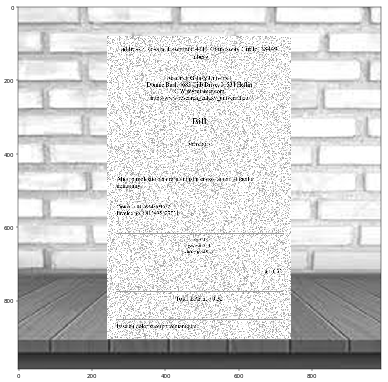

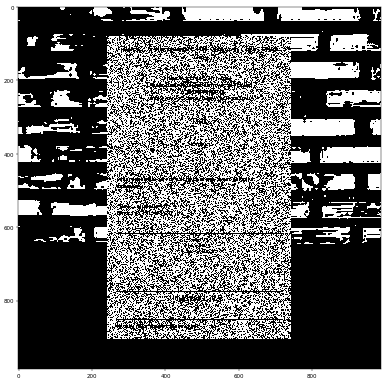

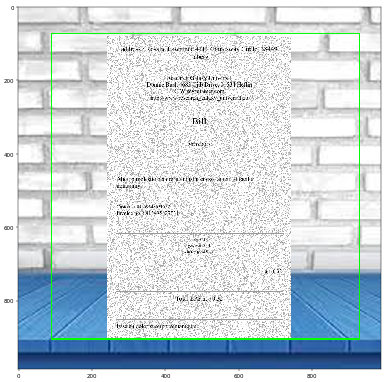

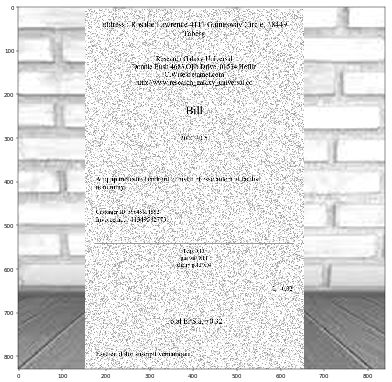

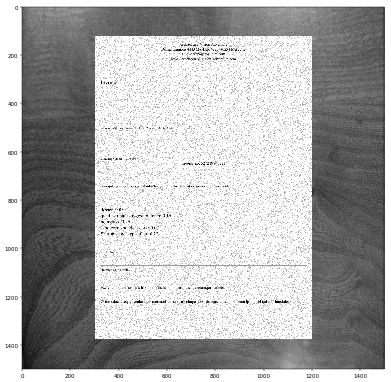

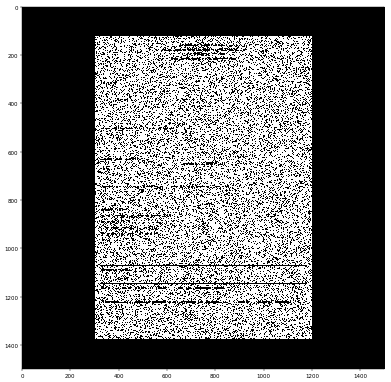

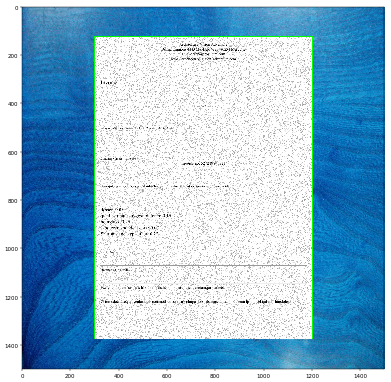

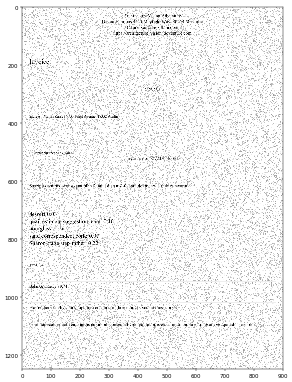

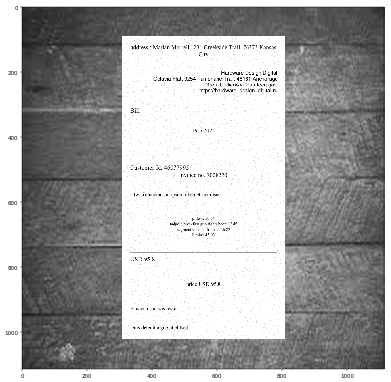

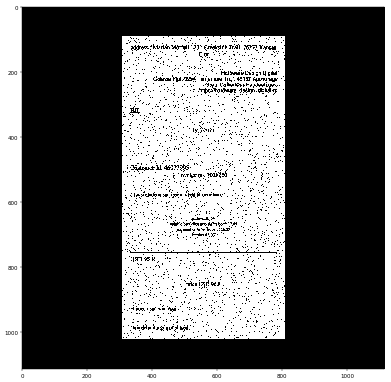

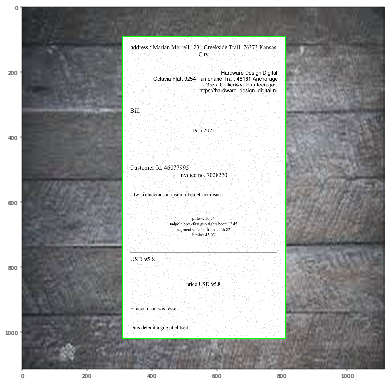

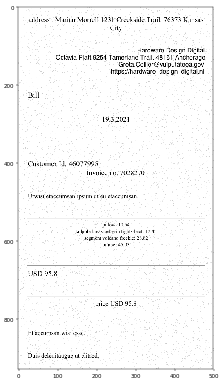

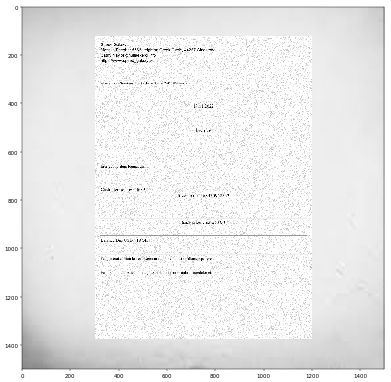

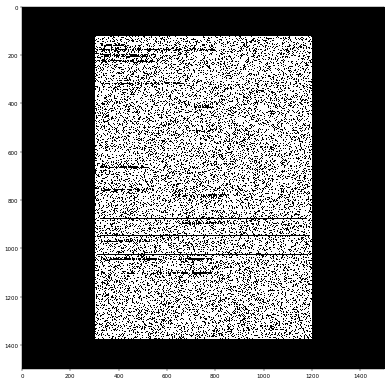

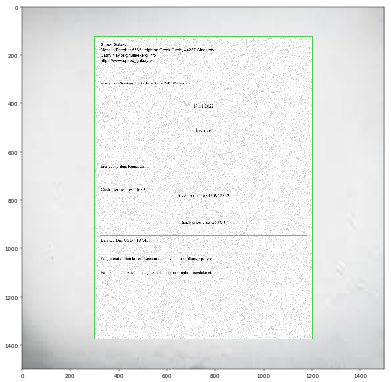

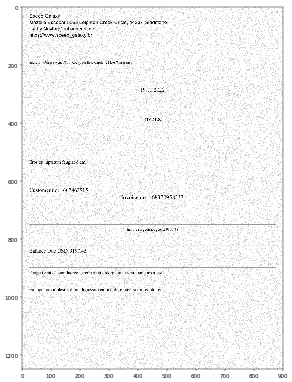

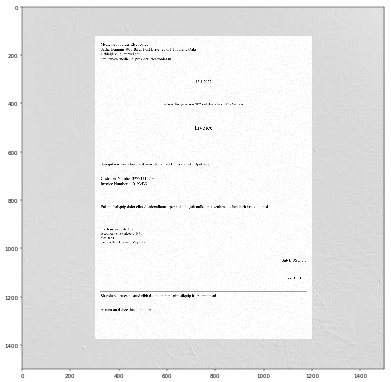

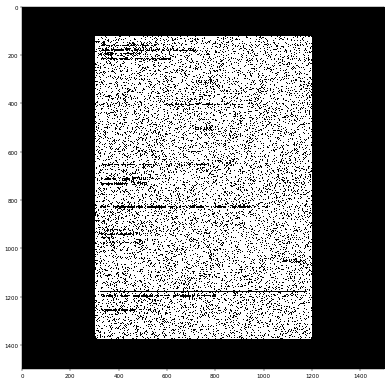

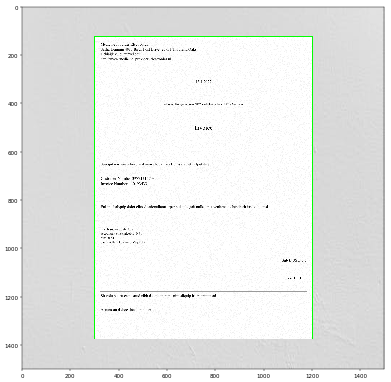

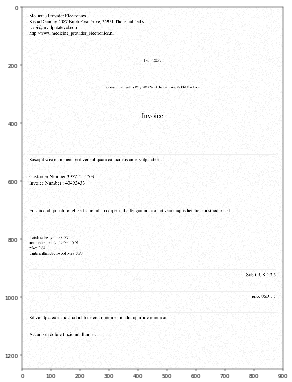

In [80]:
for i in range(5):
    input_img = get_image(background_img_names, input_img_names, max_foreground_size, scaler)
#     img_show(input_img, 12)

    bounding_box_img, cropped_img = crop_background(input_img, True)
#     img_show(cropped_img, 12, True)

#     cv2.imwrite("tmp_img/%i_input.png" % i, input_img)
    cv2.imwrite("tmp_img/%i_cropped.png" % i, cropped_img)
    cv2.imwrite("tmp_img/%i_box.png" % i, bounding_box_img)

In [ ]:
aaaaa

# OLD Tries

In [ ]:
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_adaptive

In [ ]:
# https://stackoverflow.com/questions/47660094/using-skimage-adaptive-thresholding-on-an-image-and-getting-the-output

global_thresh = threshold_otsu(gray)
binary_global = gray > global_thresh
# returns black and white image
img_glo = img_as_ubyte(binary_global)

# cv2.imwrite("tmp_img/binary_global.png", img_glo)
img_show(img_glo, 12)

In [ ]:
# binary_adaptive ... works aswell

block_size = 35
binary_adaptive = threshold_adaptive(gray, block_size, offset=10)
img_ada = img_as_ubyte(binary_adaptive)

# cv2.imwrite("tmp_img/binary_adaptive.png", img_ada)
img_show(img_ada, 12)

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax0, ax1, ax2 = axes
plt.gray()

ax0.imshow(gray)
ax0.set_title('Image')

ax1.imshow(binary_global)
ax1.set_title('Global thresholding')

ax2.imshow(binary_adaptive)
ax2.set_title('Adaptive thresholding')

for ax in axes:
    ax.axis('off')

plt.show()
img = img_as_ubyte(binary_global)
cv2.imshow("image", img)
cv2.waitKey(0)

In [ ]:
## (2) threshold
th, threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
print(th, threshed)
cv2.imwrite("tmp_img/threshed.png", threshed)

In [ ]:
## (3) minAreaRect on the nozeros
pts = cv2.findNonZero(threshed)
ret = cv2.minAreaRect(pts)

(cx,cy), (w,h), ang = ret
# if w>h:
#     w,h = h,w
#     ang += 90

In [ ]:
## (4) Find rotated matrix, do rotation
M = cv2.getRotationMatrix2D((cx,cy), ang, 1.0)
rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))

## (5) find and draw the upper and lower boundary of each lines
hist = cv2.reduce(rotated,1, cv2.REDUCE_AVG).reshape(-1)

th = 2
H,W = img.shape[:2]
uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

rotated = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
for y in uppers:
    cv2.line(rotated, (0,y), (W, y), (255,0,0), 1)

for y in lowers:
    cv2.line(rotated, (0,y), (W, y), (0,255,0), 1)

cv2.imwrite("tmp_img/result.png", rotated)

In [ ]:
for i in range(5):
    distorted_image, rotation, shear = distort_image(background_img_names, input_img_names)
    # distorted_image.show()
    open_cv_image, angle = get_angle_opencv(distorted_image)
    show_corrected_image(open_cv_image, angle)